In [1]:
import h5py
import torch
import numpy as np
import matplotlib.pyplot as plt

# with h5py.File(f'data_large/Burgers_train_100000_default.h5', 'r') as f:
#     # Traj_dataset.traj_train = torch.tensor(f['train']['pde_140-256'][:10000, :131], dtype=torch.float32, device=cfg.device)
#     traj = torch.tensor(f['train']['pde_140-256'][:1000, :131], dtype=torch.float32)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [2]:
import hydra
from omegaconf import DictConfig, OmegaConf
from generate_data import generate_timestep
from tqdm import tqdm

hydra.initialize(config_path="cfg_long_hal", version_base=None)
cfg = hydra.compose(config_name="config", overrides=["task=Heat", "nt=131"])

In [3]:
with h5py.File(cfg.dataset.train_path, 'r') as f:
    # Traj_dataset.traj_train = torch.tensor(f['train']['pde_140-256'][:10000, :131], dtype=torch.float32, device=cfg.device)
    traj = torch.tensor(f['train']['pde_140-256'][:1000, :131], dtype=torch.float32)

In [18]:

x = traj[0:10, :1, :]
solution = []
solution = generate_timestep(x, cfg, timesteps=130)
solution = torch.cat([x, solution], dim=1)

real = traj[0:10, :131, :]


In [13]:

x = traj[0:10, :1, :]
solution = []
y_pred = x
solution.append(y_pred)
for i in tqdm(range(cfg.nt-1)):
    y_pred = generate_timestep(solution[-1], cfg)
    solution.append(y_pred)
solution = torch.cat(solution, dim=1)

real = traj[0:10, :131, :]


  2%|▏         | 3/130 [00:00<00:12, 10.27it/s]

torch.Size([10, 1, 256])
torch.Size([10, 1, 256])
torch.Size([10, 1, 256])


  4%|▍         | 5/130 [00:00<00:11, 10.54it/s]

torch.Size([10, 1, 256])
torch.Size([10, 1, 256])
torch.Size([10, 1, 256])


  7%|▋         | 9/130 [00:00<00:11, 10.53it/s]

torch.Size([10, 1, 256])
torch.Size([10, 1, 256])
torch.Size([10, 1, 256])


  8%|▊         | 11/130 [00:01<00:11, 10.68it/s]

torch.Size([10, 1, 256])
torch.Size([10, 1, 256])
torch.Size([10, 1, 256])


 12%|█▏        | 15/130 [00:01<00:10, 10.81it/s]

torch.Size([10, 1, 256])
torch.Size([10, 1, 256])
torch.Size([10, 1, 256])


 13%|█▎        | 17/130 [00:01<00:10, 10.94it/s]

torch.Size([10, 1, 256])
torch.Size([10, 1, 256])
torch.Size([10, 1, 256])


 16%|█▌        | 21/130 [00:01<00:09, 11.39it/s]

torch.Size([10, 1, 256])
torch.Size([10, 1, 256])
torch.Size([10, 1, 256])


 18%|█▊        | 23/130 [00:02<00:09, 10.91it/s]

torch.Size([10, 1, 256])
torch.Size([10, 1, 256])
torch.Size([10, 1, 256])


 19%|█▉        | 25/130 [00:02<00:09, 10.70it/s]

torch.Size([10, 1, 256])
torch.Size([10, 1, 256])


 22%|██▏       | 29/130 [00:02<00:09, 10.22it/s]

torch.Size([10, 1, 256])
torch.Size([10, 1, 256])
torch.Size([10, 1, 256])


 24%|██▍       | 31/130 [00:02<00:09, 10.58it/s]

torch.Size([10, 1, 256])
torch.Size([10, 1, 256])
torch.Size([10, 1, 256])


 27%|██▋       | 35/130 [00:03<00:08, 11.48it/s]

torch.Size([10, 1, 256])
torch.Size([10, 1, 256])
torch.Size([10, 1, 256])


 28%|██▊       | 37/130 [00:03<00:08, 11.59it/s]

torch.Size([10, 1, 256])
torch.Size([10, 1, 256])
torch.Size([10, 1, 256])


 32%|███▏      | 41/130 [00:03<00:07, 12.39it/s]

torch.Size([10, 1, 256])
torch.Size([10, 1, 256])
torch.Size([10, 1, 256])


 33%|███▎      | 43/130 [00:03<00:06, 12.62it/s]

torch.Size([10, 1, 256])
torch.Size([10, 1, 256])
torch.Size([10, 1, 256])


 36%|███▌      | 47/130 [00:04<00:06, 12.42it/s]

torch.Size([10, 1, 256])
torch.Size([10, 1, 256])
torch.Size([10, 1, 256])


 38%|███▊      | 49/130 [00:04<00:06, 12.34it/s]

torch.Size([10, 1, 256])
torch.Size([10, 1, 256])
torch.Size([10, 1, 256])


 41%|████      | 53/130 [00:04<00:06, 12.51it/s]

torch.Size([10, 1, 256])
torch.Size([10, 1, 256])
torch.Size([10, 1, 256])


 42%|████▏     | 55/130 [00:04<00:06, 12.41it/s]

torch.Size([10, 1, 256])
torch.Size([10, 1, 256])
torch.Size([10, 1, 256])


 45%|████▌     | 59/130 [00:05<00:05, 12.31it/s]

torch.Size([10, 1, 256])
torch.Size([10, 1, 256])
torch.Size([10, 1, 256])


 47%|████▋     | 61/130 [00:05<00:05, 12.32it/s]

torch.Size([10, 1, 256])
torch.Size([10, 1, 256])
torch.Size([10, 1, 256])


 50%|█████     | 65/130 [00:05<00:05, 12.35it/s]

torch.Size([10, 1, 256])
torch.Size([10, 1, 256])
torch.Size([10, 1, 256])


 52%|█████▏    | 67/130 [00:05<00:05, 12.37it/s]

torch.Size([10, 1, 256])
torch.Size([10, 1, 256])
torch.Size([10, 1, 256])


 55%|█████▍    | 71/130 [00:06<00:04, 12.60it/s]

torch.Size([10, 1, 256])
torch.Size([10, 1, 256])
torch.Size([10, 1, 256])


 56%|█████▌    | 73/130 [00:06<00:04, 12.44it/s]

torch.Size([10, 1, 256])
torch.Size([10, 1, 256])
torch.Size([10, 1, 256])


 59%|█████▉    | 77/130 [00:06<00:04, 12.39it/s]

torch.Size([10, 1, 256])
torch.Size([10, 1, 256])
torch.Size([10, 1, 256])


 61%|██████    | 79/130 [00:06<00:04, 12.65it/s]

torch.Size([10, 1, 256])
torch.Size([10, 1, 256])
torch.Size([10, 1, 256])


 64%|██████▍   | 83/130 [00:07<00:03, 12.58it/s]

torch.Size([10, 1, 256])
torch.Size([10, 1, 256])
torch.Size([10, 1, 256])


 65%|██████▌   | 85/130 [00:07<00:03, 12.58it/s]

torch.Size([10, 1, 256])
torch.Size([10, 1, 256])
torch.Size([10, 1, 256])


 68%|██████▊   | 89/130 [00:07<00:03, 12.50it/s]

torch.Size([10, 1, 256])
torch.Size([10, 1, 256])
torch.Size([10, 1, 256])


 70%|███████   | 91/130 [00:07<00:03, 12.57it/s]

torch.Size([10, 1, 256])
torch.Size([10, 1, 256])
torch.Size([10, 1, 256])


 73%|███████▎  | 95/130 [00:07<00:02, 13.14it/s]

torch.Size([10, 1, 256])
torch.Size([10, 1, 256])
torch.Size([10, 1, 256])


 75%|███████▍  | 97/130 [00:08<00:02, 13.38it/s]

torch.Size([10, 1, 256])
torch.Size([10, 1, 256])
torch.Size([10, 1, 256])


 78%|███████▊  | 101/130 [00:08<00:02, 13.30it/s]

torch.Size([10, 1, 256])
torch.Size([10, 1, 256])
torch.Size([10, 1, 256])


 79%|███████▉  | 103/130 [00:08<00:02, 13.17it/s]

torch.Size([10, 1, 256])
torch.Size([10, 1, 256])
torch.Size([10, 1, 256])


 82%|████████▏ | 107/130 [00:08<00:01, 13.31it/s]

torch.Size([10, 1, 256])
torch.Size([10, 1, 256])
torch.Size([10, 1, 256])


 84%|████████▍ | 109/130 [00:09<00:01, 13.36it/s]

torch.Size([10, 1, 256])
torch.Size([10, 1, 256])
torch.Size([10, 1, 256])


 87%|████████▋ | 113/130 [00:09<00:01, 13.52it/s]

torch.Size([10, 1, 256])
torch.Size([10, 1, 256])
torch.Size([10, 1, 256])


 88%|████████▊ | 115/130 [00:09<00:01, 13.59it/s]

torch.Size([10, 1, 256])
torch.Size([10, 1, 256])
torch.Size([10, 1, 256])


 92%|█████████▏| 119/130 [00:09<00:00, 13.64it/s]

torch.Size([10, 1, 256])
torch.Size([10, 1, 256])
torch.Size([10, 1, 256])


 93%|█████████▎| 121/130 [00:09<00:00, 13.48it/s]

torch.Size([10, 1, 256])
torch.Size([10, 1, 256])
torch.Size([10, 1, 256])


 96%|█████████▌| 125/130 [00:10<00:00, 13.12it/s]

torch.Size([10, 1, 256])
torch.Size([10, 1, 256])
torch.Size([10, 1, 256])


 98%|█████████▊| 127/130 [00:10<00:00, 12.67it/s]

torch.Size([10, 1, 256])
torch.Size([10, 1, 256])
torch.Size([10, 1, 256])


100%|██████████| 130/130 [00:10<00:00, 12.22it/s]

torch.Size([10, 1, 256])
torch.Size([10, 1, 256])


tensor(5.8778e-07)


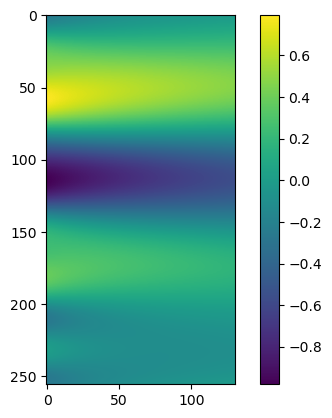

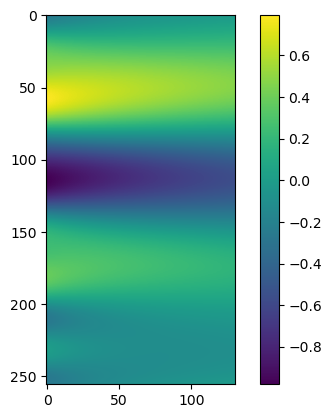

In [19]:
plt.figure()
plt.imshow(real[0].cpu().numpy().T)
plt.colorbar()

plt.figure()
plt.imshow(solution[0].cpu().numpy().T)
plt.colorbar()

print(torch.norm(real-solution) / torch.norm(real))